# temp01

In [1]:
import os
import json
from typing import NamedTuple

import torch
import pycolmap
import numpy as np
from PIL import Image
from pathlib import Path
import concurrent.futures

In [3]:
source_path = Path(data_source_path)

# Parse colmap meta data
sparse_path = source_path / "sparse" / "0"
if not sparse_path.exists():
    raise Exception("Can not find COLMAP reconstruction.")

In [4]:
sfm = pycolmap.Reconstruction(sparse_path)

In [5]:
class PointCloud(NamedTuple):
    positions: np.array
    rgb: np.array
    err: np.array
    view2points: dict


pc_positions = []
pc_rgb = []
pc_err = []
p_id = []
num_p = 0
for k, v in sfm.points3D.items():
    p_id.append(k)
    pc_positions.append(v.xyz)
    pc_rgb.append(v.color)
    pc_err.append(v.error)
    num_p += 1

pc_positions = np.array(pc_positions)
pc_rgb = np.array(pc_rgb)
pc_err = np.array(pc_err)
p_id = np.array(p_id)

points_idmap = np.full([p_id.max()+2], -1, dtype=np.int64)
points_idmap[p_id] = np.arange(num_p)

view2points = {}
for image in sfm.images.values():

    matchs = np.array([p.point3D_id for p in image.points2D if p.has_point3D()])
    matched_p_id = points_idmap[matchs]
    assert matched_p_id.min() >= 0 and matched_p_id.max() < num_p

    view2points[image.name] = matched_p_id

In [6]:
point_cloud = PointCloud(
    positions=pc_positions,
    rgb=pc_rgb,
    err=pc_err,
    view2points=view2points
)

In [ ]:
# Sort key by filename
keys = sorted(
    sfm.images.keys(),
    key = lambda k : sfm.images[k].name)


# Load all images and cameras
views_construct_list = []
for key in keys:

    view = sfm.images[key]
    
    # Load image
    image_path = source_path / image_dir_name / view.name
    if not image_path.exists():
        raise Exception(f"File not found: {str(image_path)}")
    image = Image.open(image_path)

    # Load camera intrinsic
    if view.camera.model.name == "SIMPLE_PINHOLE":
        focal_x, cx, cy = view.camera.params
        fovx = 2 * np.arctan(view.camera.width / (2 * focal_x))
        fovy = 2 * np.arctan(view.camera.width / (2 * focal_x))
        cx_p = cx / view.camera.width
        cy_p = cy / view.camera.height
    elif view.camera.model.name == "PINHOLE":
        focal_x, focal_y, cx, cy = view.camera.params
        fovx = 2 * np.arctan(view.camera.width / (2 * focal_x))
        fovy = 2 * np.arctan(view.camera.width / (2 * focal_y))
        cx_p = cx / view.camera.width
        cy_p = cy / view.camera.height
    else:
        assert False, "Colmap camera model not handled: only undistorted datasets (PINHOLE or SIMPLE_PINHOLE cameras) supported!"

    # Load camera extrinsic
    world2view = np.eye(4, dtype=np.float32)
    try:
        world2view[:3] = view.cam_from_world().matrix()
    except:
        # Older version of pycolmap
        world2view[:3] = view.cam_from_world.matrix()

    # Load points positions are seen in view
    viewed_pc = point_cloud.positions[point_cloud.view2points[view.name]]

    views_construct_list.append(dict(
        image=image,
        world2view=world2view,
        fovx=fovx,
        fovy=fovy,
        cx_p=cx_p,
        cy_p=cy_p,
        viewed_pc=viewed_pc,
        view_name=view.name,
    ))

In [8]:
# for view in views_construct_list:
#     print((view["view_name"], view["image"].size))

In [9]:
class View:
    '''
    Base class of perspective cameras - View.
    '''
    def __init__(
        self, world2view, fovx, fovy, cx_p, cy_p,
        rendered_view, viewed_pc, view_name,
        near=0.02,
    ):

        self.view_name = view_name

        # Camera/View parameters
        self.world2view = torch.tensor(world2view, dtype=torch.float32)
        self.view2world = self.world2view.inverse().contiguous()

        self.fovx = fovx
        self.fovy = fovy

        # Convert image to rendered view tensor
        self.rendered_true = torch.tensor(rendered_view, dtype=torch.float32)

        # Other camera parameters
        self.render_width = self.rendered_true.shape[2]
        self.render_height = self.rendered_true.shape[1]
        self.cx_p = cx_p
        self.cy_p = cy_p
        self.near = near

        # Load sparse depth
        if viewed_pc is not None:
            self.sparse_pt = torch.tensor(viewed_pc, dtype=torch.float32)
        else:
            self.sparse_pt = None

    def __repr__(self):
        clsname = self.__class__.__name__
        fname = f"from_image_name='{self.view_name}'"
        res = f"HW=({self.render_height}x{self.render_width})"
        fov = f"fovx={np.rad2deg(self.fovx):.1f}deg"
        return f"{clsname}({fname}, {res}, {fov})"
    
    def to(self, device):
        self.rendered_true = self.rendered_true.to(device)
        self.world2view = self.world2view.to(device)
        self.view2world = self.view2world.to(device)
        self.sparse_pt = self.sparse_pt.to(device)
        return self

    @property
    def lookat(self):
        return self.c2w[:3, 2]

    @property
    def position(self):
        return self.c2w[:3, 3]

    @property
    def down(self):
        return self.c2w[:3, 1]

    @property
    def right(self):
        return self.c2w[:3, 0]

    @property
    def cx(self):
        return self.image_width * self.cx_p

    @property
    def cy(self):
        return self.image_height * self.cy_p

    @property
    def pix_size(self):
        return 2 * self.tanfovx / self.image_width

    @property
    def tanfovx(self):
        return np.tan(self.fovx * 0.5)

    @property
    def tanfovy(self):
        return np.tan(self.fovy * 0.5)

    def project2view(self, pc_positions, return_depth=False):
        # Return normalized image coordinate in [-1, 1]
        view_coor = pc_positions @ self.w2c[:3, :3].T + self.w2c[:3, 3]
        depth = view_coor[:, [2]]
        image_uv = view_coor[:, :2] / depth
        scale_x = 1 / self.tanfovx
        scale_y = 1 / self.tanfovy
        shift_x = 2 * self.cx_p - 1
        shift_y = 2 * self.cy_p - 1
        image_uv[:, 0] = image_uv[:, 0] * scale_x + shift_x
        image_uv[:, 1] = image_uv[:, 1] * scale_y + shift_y
        if return_depth:
            return image_uv, depth
        return image_uv

# Function that create Camera instances while parsing dataset
class ViewCreator:
    def __init__(self, res_downscale=0.0, res_width=0, alpha_is_white=True):
        self.res_downscale = res_downscale
        self.res_width = res_width
        self.alpha_is_white = alpha_is_white

    def __call__(self, image, world2view, fovx, fovy, cx_p=0.5, cy_p=0.5, viewed_pc=None, view_name=""):

        # Get target resolution
        if self.res_downscale > 0:
            downscale = self.res_downscale
        elif self.res_width > 0:
            downscale = image.size[0] / self.res_width
        else:
            downscale = 1

        # Resize image if needed
        if downscale != 1:
            size = (round(image.size[0] / downscale), round(image.size[1] / downscale))
            image = image.resize(size)

        # Convert image to tensor
        img_arr = np.moveaxis(np.array(image), -1, 0) / 255.0
        if img_arr.shape[0] == 4:
            # Blend alpha channel
            img_rgb, img_alpha = img_arr[:3], img_arr[[3]]
            if not self.skip_blend_alpha:
                img_arr = img_rgb * img_alpha + int(self.alpha_is_white) * (1 - img_alpha)

        return View(
            world2view=world2view,
            fovx=fovx, fovy=fovy,
            cx_p=cx_p, cy_p=cy_p,
            rendered_view=img_arr,
            viewed_pc=viewed_pc,
            view_name=view_name
        )

In [12]:
view_creator = ViewCreator(res_downscale=0.0, res_width=1280)

In [13]:
import time

view_list = []
for todo in views_construct_list:
    
    s = time.time()
    view_list.append(view_creator(**todo))
    print(f"Done {todo["view_name"]} in {time.time()-s}s")

Done DSCF0656.JPG in 0.07212972640991211s
Done DSCF0657.JPG in 0.05663037300109863s
Done DSCF0658.JPG in 0.05621051788330078s
Done DSCF0659.JPG in 0.05687355995178223s
Done DSCF0660.JPG in 0.057381391525268555s
Done DSCF0661.JPG in 0.056700706481933594s
Done DSCF0662.JPG in 0.057385921478271484s
Done DSCF0663.JPG in 0.05751490592956543s
Done DSCF0664.JPG in 0.058919668197631836s
Done DSCF0665.JPG in 0.05674552917480469s
Done DSCF0666.JPG in 0.05681586265563965s
Done DSCF0667.JPG in 0.056684255599975586s
Done DSCF0668.JPG in 0.05840730667114258s
Done DSCF0669.JPG in 0.057270050048828125s
Done DSCF0670.JPG in 0.05785775184631348s
Done DSCF0671.JPG in 0.05805706977844238s
Done DSCF0672.JPG in 0.05922198295593262s
Done DSCF0673.JPG in 0.058416128158569336s
Done DSCF0674.JPG in 0.05691862106323242s
Done DSCF0675.JPG in 0.056778669357299805s
Done DSCF0676.JPG in 0.0583341121673584s
Done DSCF0677.JPG in 0.05804896354675293s
Done DSCF0678.JPG in 0.06113767623901367s
Done DSCF0679.JPG in 0.0576

In [15]:
import torch
import numpy as np



class View:
    '''
    Base class of perspective cameras - View.
    '''
    def __init__(
        self, world2view, fovx, fovy, cx_p, cy_p,
        rendered_view, viewed_pc, view_name,
        near=0.02,
    ):

        self.view_name = view_name

        # Camera/View parameters
        self.world2view = torch.tensor(world2view, dtype=torch.float32)
        self.view2world = self.world2view.inverse().contiguous()

        self.fovx = fovx
        self.fovy = fovy

        # Convert image to rendered view tensor
        self.rendered_true = torch.tensor(rendered_view, dtype=torch.float32)

        # Other camera parameters
        self.render_width = self.rendered_true.shape[2]
        self.render_height = self.rendered_true.shape[1]
        self.cx_p = cx_p
        self.cy_p = cy_p
        self.near = near

        # Load sparse depth
        if viewed_pc is not None:
            self.sparse_pt = torch.tensor(viewed_pc, dtype=torch.float32)
        else:
            self.sparse_pt = None

    def __repr__(self):
        clsname = self.__class__.__name__
        fname = f"from_image_name='{self.view_name}'"
        res = f"HW=({self.render_height}x{self.render_width})"
        fov = f"fovx={np.rad2deg(self.fovx):.1f}deg"
        return f"{clsname}({fname}, {res}, {fov})"
    
    def to(self, device):
        self.rendered_true = self.rendered_true.to(device)
        self.world2view = self.world2view.to(device)
        self.view2world = self.view2world.to(device)
        self.sparse_pt = self.sparse_pt.to(device)
        return self

    @property
    def lookat(self):
        return self.c2w[:3, 2]

    @property
    def position(self):
        return self.c2w[:3, 3]

    @property
    def down(self):
        return self.c2w[:3, 1]

    @property
    def right(self):
        return self.c2w[:3, 0]

    @property
    def cx(self):
        return self.image_width * self.cx_p

    @property
    def cy(self):
        return self.image_height * self.cy_p

    @property
    def pix_size(self):
        return 2 * self.tanfovx / self.image_width

    @property
    def tanfovx(self):
        return np.tan(self.fovx * 0.5)

    @property
    def tanfovy(self):
        return np.tan(self.fovy * 0.5)

    def project2view(self, pc_positions, return_depth=False):
        # Return normalized image coordinate in [-1, 1]
        view_coor = pc_positions @ self.w2c[:3, :3].T + self.w2c[:3, 3]
        depth = view_coor[:, [2]]
        image_uv = view_coor[:, :2] / depth
        scale_x = 1 / self.tanfovx
        scale_y = 1 / self.tanfovy
        shift_x = 2 * self.cx_p - 1
        shift_y = 2 * self.cy_p - 1
        image_uv[:, 0] = image_uv[:, 0] * scale_x + shift_x
        image_uv[:, 1] = image_uv[:, 1] * scale_y + shift_y
        if return_depth:
            return image_uv, depth
        return image_uv

# Function that create Camera instances while parsing dataset
class ViewCreator:
    def __init__(self, res_downscale=0.0, res_width=0):
        self.res_downscale = res_downscale
        self.res_width = res_width

    def __call__(self, image, world2view, fovx, fovy, cx_p=0.5, cy_p=0.5, viewed_pc=None, view_name=""):

        # Get target resolution
        if self.res_downscale > 0:
            downscale = self.res_downscale
        elif self.res_width > 0:
            downscale = image.size[0] / self.res_width
        else:
            downscale = 1

        # Resize image if needed
        if downscale != 1:
            size = (round(image.size[0] / downscale), round(image.size[1] / downscale))
            image = image.resize(size)

        # Convert image to tensor
        img_arr = np.moveaxis(np.array(image), -1, 0) / 255.0
        if img_arr.shape[0] == 4:
            img_arr, alpha_channel = img_arr[:3], img_arr[[3]]


        return View(
            world2view=world2view,
            fovx=fovx, fovy=fovy,
            cx_p=cx_p, cy_p=cy_p,
            rendered_view=img_arr,
            viewed_pc=viewed_pc,
            view_name=view_name
        )


In [ ]:
import time

view_list = []
for todo in views_construct_list:
    
    s = time.time()
    view_list.append(view_creator(**todo))
    print(f"Done {todo["view_name"]} in {time.time()-s}s")

# Temp02

In [27]:
import os
PROJECT_ROOT = "/home/dotamthuc-3090/Projects/ViewSynthesis/"
print("PROJECT_ROOT:", PROJECT_ROOT)

import sys
lib_svraster = "/home/dotamthuc-3090/Projects/ViewSynthesis/Differentiable3DPC-Decompression-and-Rendering"
sys.path.insert(0, lib_svraster)

import numpy as np
from matplotlib.pylab import plt

from libs.dataloader.View import View, ViewCreator
from libs.dataloader.Scene import Scene

PROJECT_ROOT: /home/dotamthuc-3090/Projects/ViewSynthesis/


In [2]:
source_path = "/home/dotamthuc-3090/Projects/ViewSynthesis/data/360_v2/kitchen/"

In [3]:
scene_dataset = Scene(
    source_path, image_dir_name="images",
    res_downscale=0.0, res_width=1280,
    test_every=-1
)

Read dataset in COLMAP format.


In [4]:
scene_dataset.point_cloud.positions.min(axis=0)

array([-21.84321869, -26.09001815, -22.10813442])

In [5]:
train_views = scene_dataset.get_train_views()
test_views = scene_dataset.get_test_views()
len(train_views), len(test_views)

(279, 0)

In [57]:
view.render_height

854

/tmp/ipykernel_27584/1317550373.py:9: RuntimeWarning: invalid value encountered in divide
  depth_img = np.zeros((view.render_height, view.render_width, 1))/0


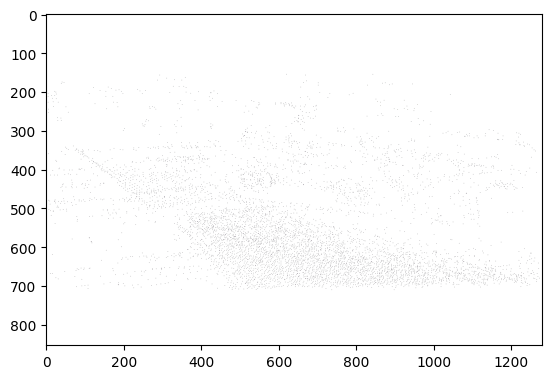

In [64]:
view = train_views[0]
img_uv, depth = view.project2view(view.viewed_pc, return_depth=True)

img_uv[:, 0] = img_uv[:, 0] * view.render_width/2 + view.render_width/2
img_uv[:, 1] = img_uv[:, 1] * view.render_height/2 + view.render_height/2

img_pixel_loc = np.int32(img_uv.numpy())

depth_img = np.zeros((view.render_height, view.render_width, 1))/0
depth_img[img_pixel_loc[:, 1], img_pixel_loc[:, 0]] = depth

plt.imshow(depth_img)

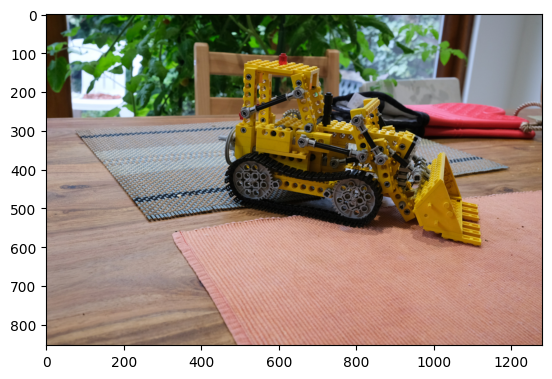

In [65]:
plt.imshow(view.rendered_true.permute(1, 2, 0).numpy())

In [7]:
view.lookat, view.position, view.down, view.right

(tensor([ 0.7735, -0.0862,  0.6280]),
 tensor([-3.5042,  1.9112, -0.7311]),
 tensor([-0.2196,  0.8929,  0.3931]),
 tensor([ 0.5946,  0.4420, -0.6717]))

View(from_image_name='DSCF0656.JPG', HW=(854x1280), fovx=51.5deg)


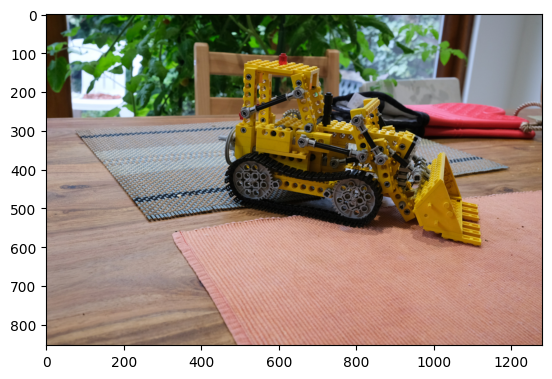

View(from_image_name='DSCF0684.JPG', HW=(854x1280), fovx=51.5deg)


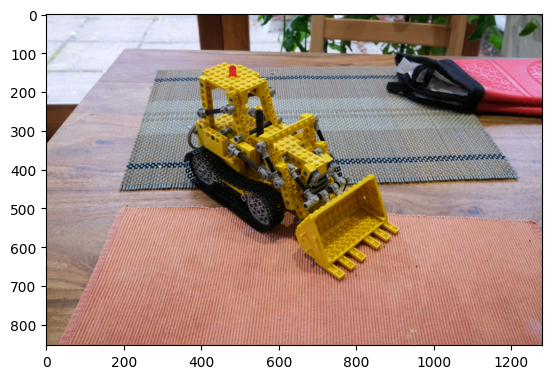

View(from_image_name='DSCF0712.JPG', HW=(854x1280), fovx=51.5deg)


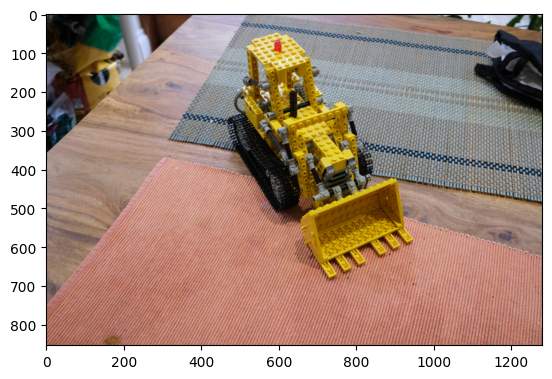

View(from_image_name='DSCF0740.JPG', HW=(854x1280), fovx=51.5deg)


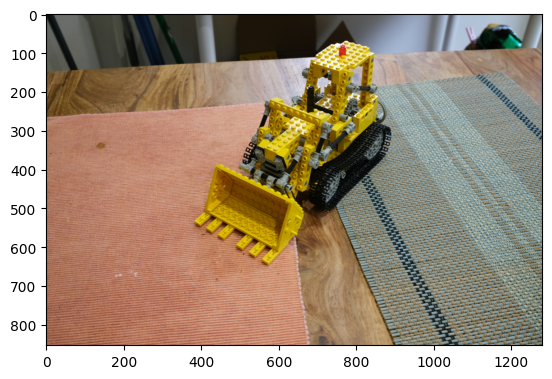

View(from_image_name='DSCF0768.JPG', HW=(854x1280), fovx=51.5deg)


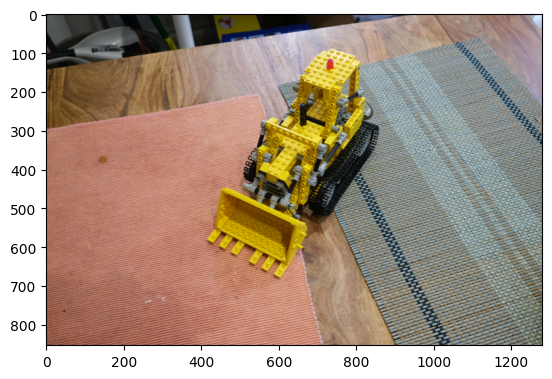

View(from_image_name='DSCF0796.JPG', HW=(854x1280), fovx=51.5deg)


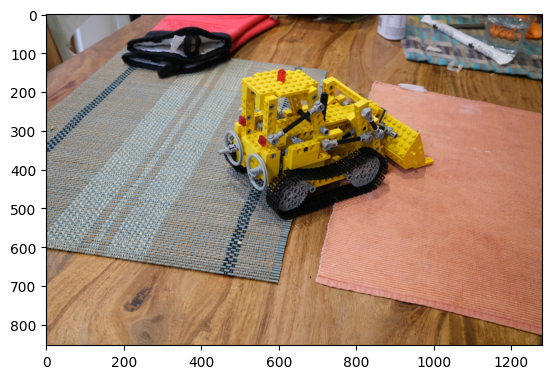

View(from_image_name='DSCF0824.JPG', HW=(854x1280), fovx=51.5deg)


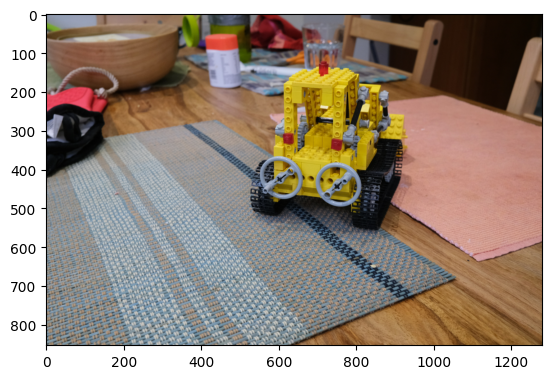

View(from_image_name='DSCF0852.JPG', HW=(854x1280), fovx=51.5deg)


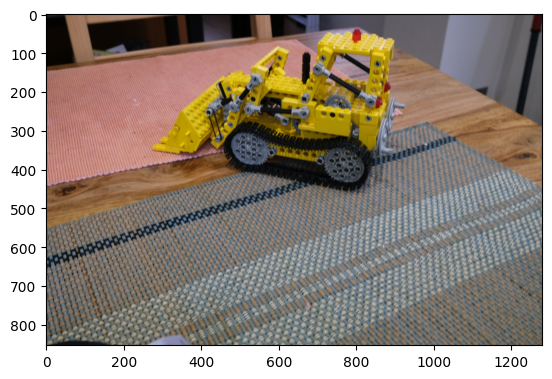

View(from_image_name='DSCF0880.JPG', HW=(854x1280), fovx=51.5deg)


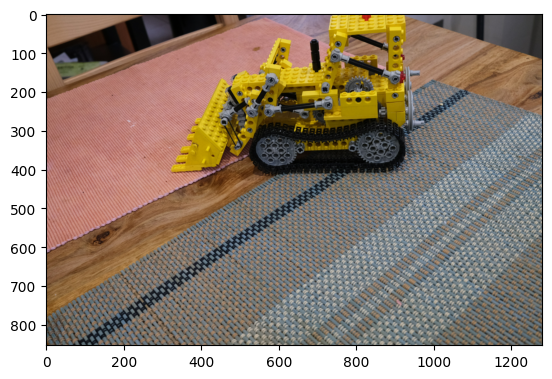

View(from_image_name='DSCF0908.JPG', HW=(854x1280), fovx=51.5deg)


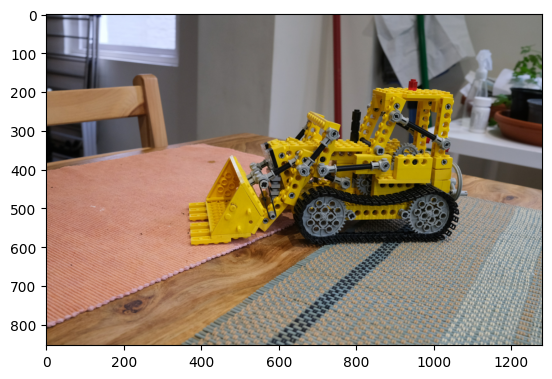

In [7]:
from matplotlib.pylab import plt

i = 0
for view in train_views:
    if (i % 28 == 0):
        print(view)
        plt.imshow(view.rendered_true.permute(1, 2, 0).numpy())
        plt.show()
    i+=1

